<a href="https://colab.research.google.com/github/debashisdotchatterjee/Robust-Power-Moment-Scale-Estimation-under-Contamination1/blob/main/Afresh_Robust_Power_Moment_Scale_Estimation_under_Contamination_(Shared_with_SOM_da_2026_).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

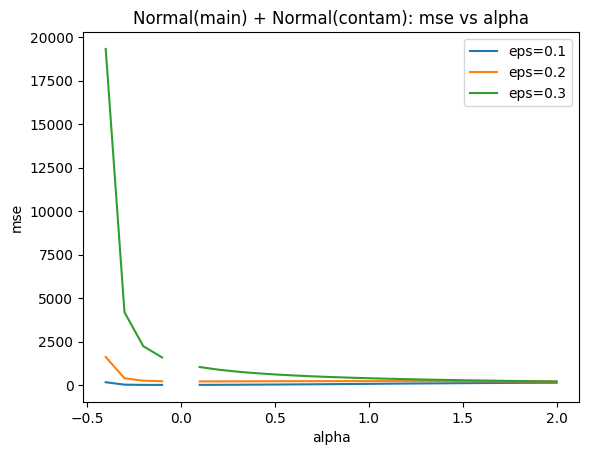

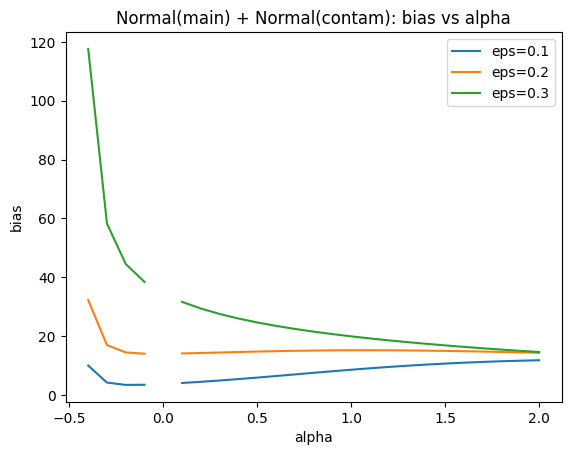

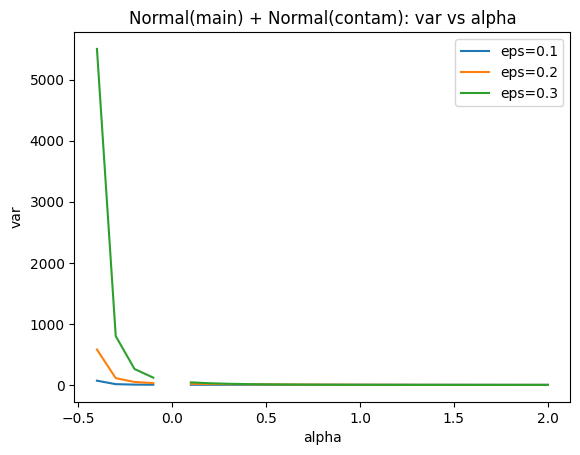

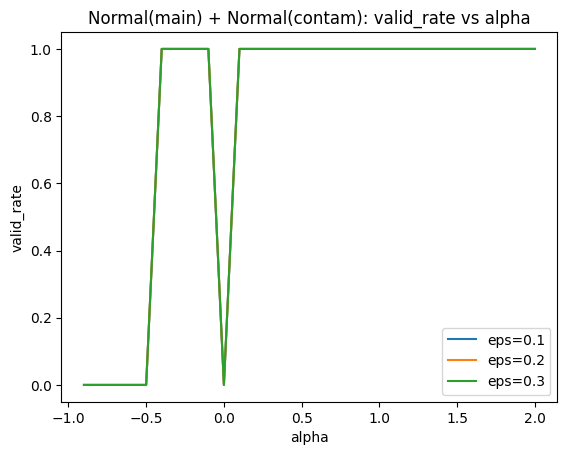

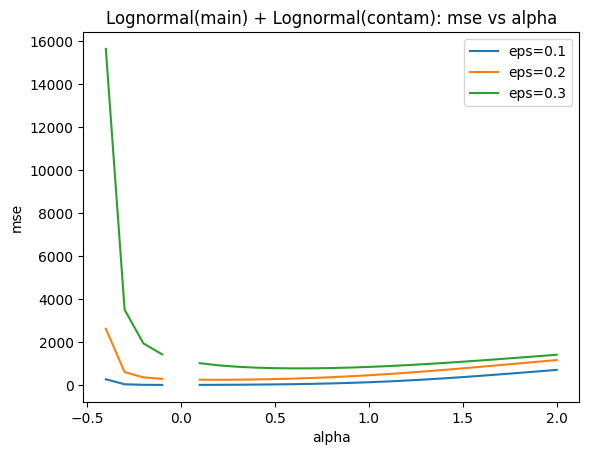

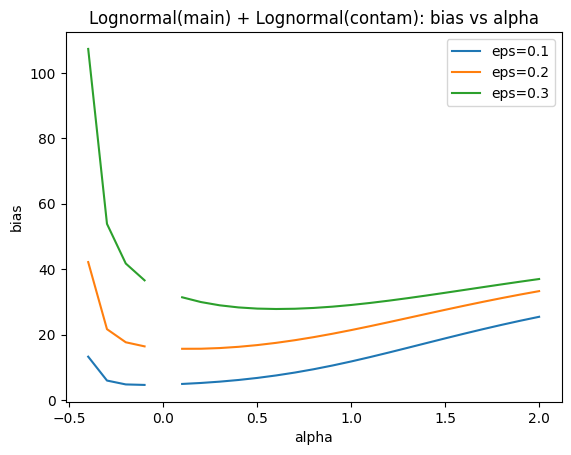

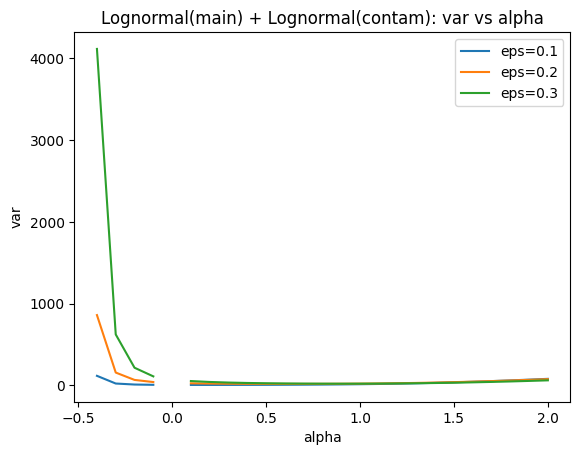

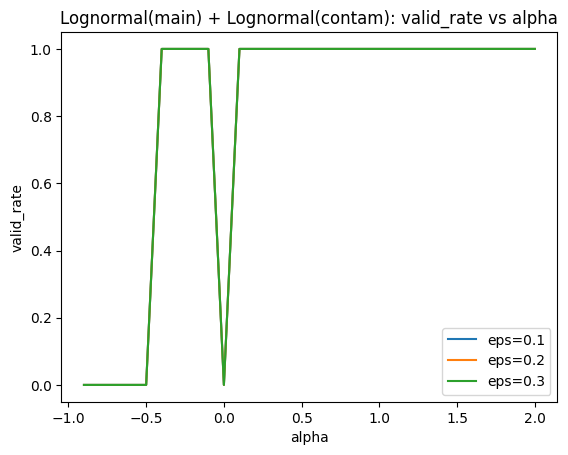

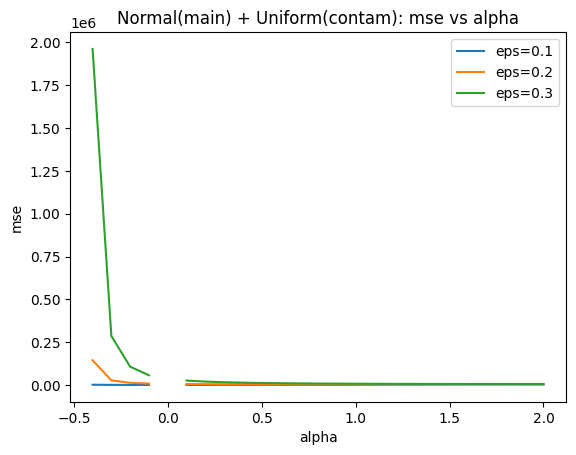

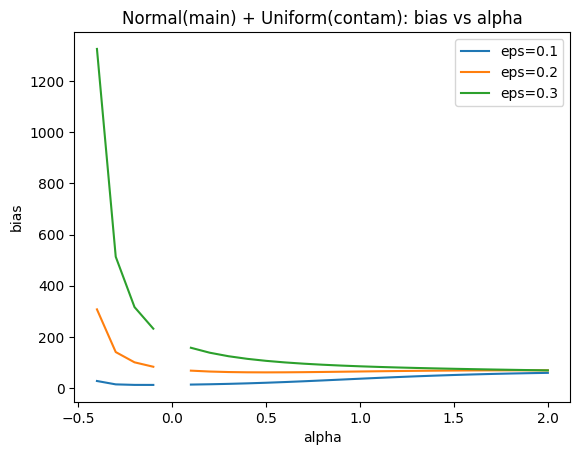

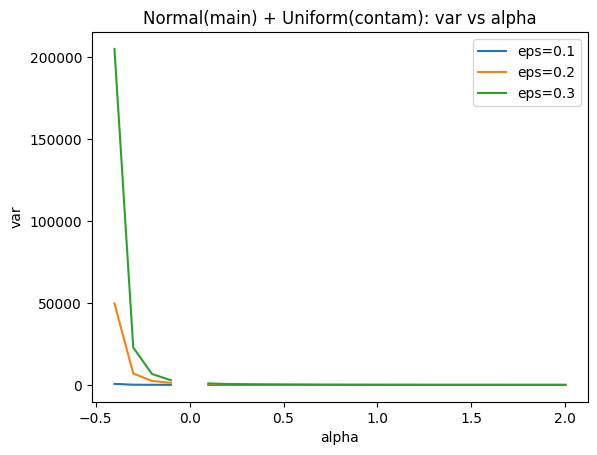

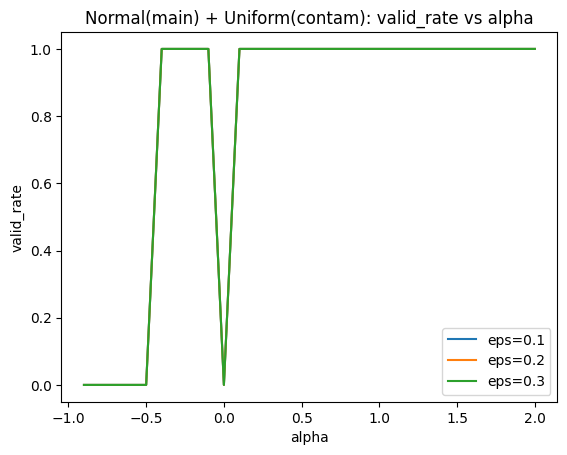

(PosixPath('robust_power_moment_simulation.zip'),
 PosixPath('robust_power_moment_simulation/tables/simulation_summary_all.csv'),
 PosixPath('robust_power_moment_simulation/tables/best_alpha_by_mse_positive_alpha.csv'),
 [PosixPath('robust_power_moment_simulation/figs/mse_Lognormalmain_plus_Lognormalcontam.png'),
  PosixPath('robust_power_moment_simulation/figs/mse_Normalmain_plus_Normalcontam.png'),
  PosixPath('robust_power_moment_simulation/figs/validrate_Normalmain_plus_Uniformcontam.png')])

In [5]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, os, zipfile, textwrap, math, warnings
from pathlib import Path

# Install the necessary package
#!pip install caas_jupyter_tools

# -----------------------------
# Output folders
# -----------------------------
base = Path("robust_power_moment_simulation")
fig_dir = base / "figs"
tab_dir = base / "tables"
base.mkdir(parents=True, exist_ok=True)
fig_dir.mkdir(parents=True, exist_ok=True)
tab_dir.mkdir(parents=True, exist_ok=True)

# -----------------------------
# Core estimator
# -----------------------------
def moment_m_alpha(alpha: float, baseline: str = "normal", mc_size: int = 2_000_000, seed: int = 1234):
    """
    Compute m(alpha) = E(|U|^(2alpha)) for baseline U.
    For Normal baseline, use closed form (stable).
    For others, fall back to Monte Carlo.
    """
    if baseline.lower() == "normal":
        # U ~ N(0,1): E|U|^p = 2^(p/2) * Gamma((p+1)/2) / sqrt(pi), p > -1
        p = 2*alpha
        if p <= -1:
            return np.nan
        from math import sqrt, pi
        import mpmath as mp
        return float((2**(p/2)) * mp.gamma((p+1)/2) / sqrt(pi))
    else:
        rng = np.random.default_rng(seed)
        if baseline.lower() == "laplace":
            U = rng.laplace(0.0, 1/np.sqrt(2), size=mc_size)  # variance 1
        elif baseline.lower() == "logistic":
            # Standard logistic var = pi^2/3; scale to var 1
            U0 = rng.logistic(0.0, 1.0, size=mc_size)
            U = U0 / (np.pi/np.sqrt(3))
        else:
            raise ValueError("Unknown baseline")
        return float(np.mean(np.abs(U)**(2*alpha)))

def Tn_alpha(x: np.ndarray, alpha: float, m_alpha: float):
    """
    T_n(alpha) = ( S_n(alpha) / m(alpha) )^(1/alpha)
    where S_n(alpha) = mean( |x - mean(x)|^(2alpha) )
    Returns np.nan if undefined (e.g., alpha=0, m_alpha<=0, or numerical issues).
    """
    if alpha == 0 or not np.isfinite(alpha):
        return np.nan
    if m_alpha is None or not np.isfinite(m_alpha) or m_alpha <= 0:
        return np.nan
    z = x - np.mean(x)
    absz = np.abs(z)
    # If alpha is negative and any absz is zero -> infinite moment; return nan truthfully.
    if alpha < 0 and np.any(absz == 0):
        return np.nan
    with np.errstate(over='ignore', divide='ignore', invalid='ignore'):
        Sn = np.mean(absz**(2*alpha))
        if not np.isfinite(Sn) or Sn <= 0:
            return np.nan
        return float((Sn / m_alpha)**(1/alpha))

# -----------------------------
# Contamination scenarios (as per Soumalya note)
# -----------------------------
def sample_mixture_normal_normal(n, eps, muF=10.0, sigmaF=2.0, muG=20.0, sigmaG=1.0, rng=None):
    rng = np.random.default_rng() if rng is None else rng
    isG = rng.random(n) < eps
    x = np.empty(n)
    x[~isG] = rng.normal(muF, sigmaF, size=np.sum(~isG))
    x[isG] = rng.normal(muG, sigmaG, size=np.sum(isG))
    return x

def sample_mixture_lognorm_lognorm(n, eps, muF=10.0, sigmaF=2.0, rng=None):
    """
    Lognormal F and G 'sufficiently apart'.
    We choose parameters so that the *main* component has mean ~ muF and sd ~ sigmaF (approx),
    and the contaminant is shifted upward in log-space (heavier/larger).

    Note: For lognormal, mean and sd determine underlying (m,s) where:
        mean = exp(m + s^2/2), var = (exp(s^2)-1) exp(2m + s^2).
    We solve for (m,s) for F, then inflate/shift for G.
    """
    rng = np.random.default_rng() if rng is None else rng

    def lognorm_params_from_mean_sd(mean, sd):
        var = sd**2
        s2 = np.log(1 + var/(mean**2))
        s = np.sqrt(s2)
        m = np.log(mean) - s2/2
        return m, s

    mF, sF = lognorm_params_from_mean_sd(muF, sigmaF)
    # contaminant: larger location and slightly larger spread in log-scale
    mG = mF + 0.7
    sG = sF * 1.25

    isG = rng.random(n) < eps
    x = np.empty(n)
    x[~isG] = rng.lognormal(mean=mF, sigma=sF, size=np.sum(~isG))
    x[isG] = rng.lognormal(mean=mG, sigma=sG, size=np.sum(isG))
    return x, (mF,sF,mG,sG)

def sample_mixture_normal_uniform(n, eps, muF=10.0, sigmaF=2.0, a=25.0, b=35.0, rng=None):
    rng = np.random.default_rng() if rng is None else rng
    isG = rng.random(n) < eps
    x = np.empty(n)
    x[~isG] = rng.normal(muF, sigmaF, size=np.sum(~isG))
    x[isG] = rng.uniform(a, b, size=np.sum(isG))
    return x

# -----------------------------
# Simulation driver
# -----------------------------
def run_simulation(
    scenario_name: str,
    sampler,
    true_sigma2: float,
    eps_list=(0.1,0.2,0.3),
    n=200,
    R=2000,
    alpha_grid=None,
    baseline="normal",
    seed=2026,
):
    rng = np.random.default_rng(seed)
    if alpha_grid is None:
        alpha_grid = np.round(np.arange(-0.9, 2.01, 0.1), 2)  # as note suggests (-1,2) roughly

    # Precompute m(alpha) for all alphas
    m_vals = {}
    for a in alpha_grid:
        # for normal baseline, closed form available; validity requires 2a > -1 => a > -0.5
        # We'll still compute but may return nan for invalid.
        try:
            m_vals[a] = moment_m_alpha(a, baseline=baseline)
        except Exception:
            m_vals[a] = np.nan

    rows = []
    # For each eps and alpha, compute Monte Carlo bias/var/mse on Tn(alpha)
    for eps in eps_list:
        # Store T values per alpha to compute var
        Tvals = {a: [] for a in alpha_grid}
        # Run R replications
        extra_meta = None
        for r in range(R):
            out = sampler(n, eps, rng=rng)
            if isinstance(out, tuple):
                x, extra_meta = out
            else:
                x = out
            for a in alpha_grid:
                m_a = m_vals[a]
                t = Tn_alpha(x, a, m_a)
                Tvals[a].append(t)
        # Summarize
        for a in alpha_grid:
            arr = np.array(Tvals[a], dtype=float)
            valid = np.isfinite(arr)
            if valid.sum() == 0:
                mean = np.nan; var = np.nan; bias = np.nan; mse = np.nan
                valid_rate = 0.0
            else:
                mean = float(np.nanmean(arr[valid]))
                var = float(np.nanvar(arr[valid], ddof=1)) if valid.sum() > 1 else np.nan
                bias = mean - true_sigma2
                mse = var + bias**2 if np.isfinite(var) else np.nan
                valid_rate = float(valid.mean())
            rows.append({
                "scenario": scenario_name,
                "n": n,
                "R": R,
                "eps": eps,
                "alpha": float(a),
                "m_alpha": float(m_vals[a]) if np.isfinite(m_vals[a]) else np.nan,
                "valid_rate": valid_rate,
                "mean_T": mean,
                "bias": bias,
                "var": var,
                "mse": mse
            })
    df = pd.DataFrame(rows)
    return df

# -----------------------------
# Parameters
# -----------------------------
n = 200
R = 2000
eps_list = (0.1, 0.2, 0.3)
alpha_grid = np.round(np.arange(-0.9, 2.01, 0.1), 2)

# True target variance of main component
true_sigma2_normal = 2.0**2  # for Normal main component
true_sigma2_logn = 2.0**2    # we still target sd=2 for main component by construction

# Run
df_nn = run_simulation(
    "Normal(main) + Normal(contam)",
    lambda n, eps, rng: sample_mixture_normal_normal(n, eps, muF=10, sigmaF=2, muG=20, sigmaG=1, rng=rng),
    true_sigma2=true_sigma2_normal,
    eps_list=eps_list, n=n, R=R, alpha_grid=alpha_grid, baseline="normal", seed=2026
)

df_lnl = run_simulation(
    "Lognormal(main) + Lognormal(contam)",
    lambda n, eps, rng: sample_mixture_lognorm_lognorm(n, eps, muF=10, sigmaF=2, rng=rng),
    true_sigma2=true_sigma2_logn,
    eps_list=eps_list, n=n, R=R, alpha_grid=alpha_grid, baseline="normal", seed=2027
)

df_nu = run_simulation(
    "Normal(main) + Uniform(contam)",
    lambda n, eps, rng: sample_mixture_normal_uniform(n, eps, muF=10, sigmaF=2, a=25, b=35, rng=rng),
    true_sigma2=true_sigma2_normal,
    eps_list=eps_list, n=n, R=R, alpha_grid=alpha_grid, baseline="normal", seed=2028
)

df_all = pd.concat([df_nn, df_lnl, df_nu], ignore_index=True)

# Save tables
csv_path = tab_dir / "simulation_summary_all.csv"
df_all.to_csv(csv_path, index=False)

# Create compact "best alpha by MSE" table (within positive admissible region)
df_pos = df_all[df_all["alpha"] > 0].copy()
best = (df_pos.sort_values(["scenario","eps","mse"])
        .groupby(["scenario","eps"], as_index=False)
        .first()[["scenario","eps","alpha","mse","bias","var","valid_rate"]])
best_path = tab_dir / "best_alpha_by_mse_positive_alpha.csv"
best.to_csv(best_path, index=False)

# -----------------------------
# Plotting helpers (matplotlib, no explicit colors)
# -----------------------------
def plot_metric(df, scenario, metric, outname):
    d = df[df["scenario"] == scenario].copy()
    # Keep only rows where metric finite
    plt.figure()
    for eps in sorted(d["eps"].unique()):
        dd = d[d["eps"] == eps].sort_values("alpha")
        plt.plot(dd["alpha"].to_numpy(), dd[metric].to_numpy(), label=f"eps={eps}")
    plt.xlabel("alpha")
    plt.ylabel(metric)
    plt.title(f"{scenario}: {metric} vs alpha")
    plt.legend()
    p = fig_dir / outname
    plt.savefig(p, dpi=200, bbox_inches="tight")
    plt.show()
    plt.close()


scenarios = df_all["scenario"].unique().tolist()
for sc in scenarios:
    plot_metric(df_all, sc, "mse", f"mse_{sc.replace(' ','_').replace('+','plus').replace('(','').replace(')','')}.png")
    plot_metric(df_all, sc, "bias", f"bias_{sc.replace(' ','_').replace('+','plus').replace('(','').replace(')','')}.png")
    plot_metric(df_all, sc, "var", f"var_{sc.replace(' ','_').replace('+','plus').replace('(','').replace(')','')}.png")
    plot_metric(df_all, sc, "valid_rate", f"validrate_{sc.replace(' ','_').replace('+','plus').replace('(','').replace(')','')}.png")

# -----------------------------
# Human-readable README (truthful notes about negative alpha)
# -----------------------------
readme = base / "README.txt"
readme.write_text(textwrap.dedent(f"""
Robust Power–Moment Scale Estimation Simulation
================================================

What is simulated?
------------------
We simulate the estimator
    T_n(alpha) = ( S_n(alpha) / m(alpha) )^(1/alpha),
    S_n(alpha) = mean( |X_i - Xbar|^(2 alpha) ),  with Xbar = sample mean.
Target parameter is theta = sigma^2 of the MAIN (uncontaminated) component.

Scenarios (following the co-author note):
-----------------------------------------
1) Normal(main) + Normal(contam):     F = N(10, 2^2),  G = N(20, 1^2)
2) Lognormal(main) + Lognormal(contam):
   Main component parameters are chosen so that mean≈10 and sd≈2 (lognormal moment-matching),
   contaminant is shifted upward in log-space (mG = mF + 0.7) with 25% larger log-sd.
3) Normal(main) + Uniform(contam):   F = N(10, 2^2),  G = Unif(25, 35)

Contamination fractions: eps in {eps_list}
Sample size: n={n}
Monte Carlo repetitions per (scenario, eps): R={R}

Alpha grid:
-----------
alpha runs from -0.9 to 2.0 in steps of 0.1 (as in the note's broad suggestion).
IMPORTANT (truthful): for alpha <= -0.5, m(alpha)=E|N(0,1)|^(2alpha) does not exist (diverges),
so the estimator is undefined. Even for alpha<0 but > -0.5, the sample statistic can still be undefined
whenever any |X_i - Xbar| = 0 (raising to a negative power). In such cases we record NaN and report
'valid_rate' = fraction of replications with a finite estimator.

Outputs:
--------
tables/simulation_summary_all.csv
    Full grid results with mean, bias, variance, MSE, valid_rate.

tables/best_alpha_by_mse_positive_alpha.csv
    Best alpha (min MSE) within alpha>0 for each (scenario, eps).

figs/*.png
    MSE, bias, variance, and valid_rate vs alpha plots for each scenario.

Reproducibility:
----------------
Random seeds fixed inside the script. All calculations use numpy/pandas/matplotlib.
""").strip())

# -----------------------------
# Zip everything
# -----------------------------
zip_path = Path("robust_power_moment_simulation.zip")
with zipfile.ZipFile(zip_path, "w", compression=zipfile.ZIP_DEFLATED) as z:
    for p in base.rglob("*"):
        if p.is_file():
            z.write(p, arcname=str(p.relative_to(base)))

# Display key tables for user
#from caas_jupyter_tools import display_dataframe_to_user
#display_dataframe_to_user("Best alpha by MSE (alpha>0)", best)
#display_dataframe_to_user("Simulation summary (first 50 rows)", df_all.head(50))

zip_path, csv_path, best_path, list(fig_dir.glob("*.png"))[:3]

In [6]:
"""
Thumb-rule (Step V) for choosing alpha on REAL data + (optional) validation checks
WITHOUT repeating the big Monte Carlo simulation you already ran.

What this script does (separately from the previous simulation):
---------------------------------------------------------------
A) Implements the estimator:
   T_n(alpha) = ( S_n(alpha) / m(alpha) )^(1/alpha),
   S_n(alpha) = mean(|X - Xbar|^(2 alpha)).

B) Implements the REAL-DATA thumb-rule suggested by the note:
   - choose alpha by SUBSAMPLING STABILITY (data-only; no theta, no eps, no G).
   - optionally compute an "elbow" alpha as a secondary diagnostic.

C) Implements the "check whether alpha lies in the Step III domain":
   - for each alpha, checks if m(alpha)=E|U|^(2 alpha) is finite for the assumed baseline.
   - for Gaussian baseline, m(alpha) is finite iff alpha > -1/2; here we restrict to alpha>0 anyway.

D) OPTIONAL (small, separate) sanity check in a “laboratory”:
   - generate ONE sample (or a small number of samples) under each scenario and eps
     and compare:
       alpha_stab (thumb-rule) vs alpha_oracle (minimizes plug-in MSE on that *same* sample)
   This is not the earlier full simulation grid with R=2000; it’s a separate light check.

How to use:
-----------
1) If you have a real dataset in a 1-column CSV, set REALDATA_PATH and run.
2) Or run the optional light lab-check section at the bottom.

Dependencies:
-------------
numpy, pandas, scipy, matplotlib
"""

import numpy as np
import pandas as pd
import math
from dataclasses import dataclass
from typing import Callable, Dict, Tuple, List, Optional

from scipy.special import gamma
import matplotlib.pyplot as plt


# ----------------------------
# 0) Baseline moment m(alpha)
# ----------------------------
def m_alpha_gaussian(alpha: float) -> float:
    """
    m(alpha) = E|U|^(2 alpha) for U ~ N(0,1).
    Closed form: E|U|^p = 2^(p/2) * Gamma((p+1)/2) / sqrt(pi) for p>-1.
    Here p = 2 alpha, hence requirement: 2 alpha > -1 <=> alpha > -1/2.
    """
    p = 2.0 * alpha
    if p <= -1.0:
        return float("inf")
    return (2.0 ** (p / 2.0)) * gamma((p + 1.0) / 2.0) / math.sqrt(math.pi)


# ----------------------------------------------------
# 1) Estimator T_n(alpha) for target main variance
# ----------------------------------------------------
def Tn_alpha(x: np.ndarray, alpha: float, mfunc: Callable[[float], float]) -> float:
    """
    Computes T_n(alpha) = (S_n(alpha)/m(alpha))^(1/alpha), with S_n(alpha)=mean(|x-xbar|^(2alpha)).
    Assumes alpha != 0. We use alpha>0 for rigorous “moment” regime.
    """
    if alpha == 0:
        raise ValueError("alpha=0 not supported in this definition.")
    x = np.asarray(x, dtype=float)
    xbar = np.mean(x)
    resid = np.abs(x - xbar)
    S = np.mean(resid ** (2.0 * alpha))
    m = mfunc(alpha)
    if not np.isfinite(m) or m <= 0:
        return np.nan
    if S <= 0:
        return np.nan
    return (S / m) ** (1.0 / alpha)


# ----------------------------------------------------
# 2) Step III “domain check” (moment feasibility)
# ----------------------------------------------------
def admissible_alpha_grid(alpha_grid: np.ndarray, mfunc: Callable[[float], float]) -> np.ndarray:
    """
    Returns boolean mask for which alpha have finite, positive m(alpha).
    For Gaussian baseline, this essentially means alpha > -1/2.
    We typically restrict to alpha>0 anyway.
    """
    ok = []
    for a in alpha_grid:
        m = mfunc(float(a))
        ok.append(np.isfinite(m) and (m > 0))
    return np.array(ok, dtype=bool)


# ----------------------------------------------------
# 3) Step V thumb-rule: subsampling stability
# ----------------------------------------------------
@dataclass
class ThumbRuleResult:
    alpha_star: float
    stability_curve: pd.DataFrame  # columns: alpha, stab, valid_rate
    elbow_alpha: Optional[float]


def alpha_by_subsample_stability(
    x: np.ndarray,
    alpha_grid: np.ndarray,
    mfunc: Callable[[float], float],
    B: int = 200,
    rho: float = 0.70,
    seed: int = 123,
    use_log: bool = True
) -> ThumbRuleResult:
    """
    Computes Stab_B(alpha) = SD(log T_b(alpha)) across B subsamples of size floor(rho n).
    Also reports valid_rate(alpha) = fraction of subsamples where T_b(alpha) is finite.
    Returns alpha minimizing stability among alphas with high valid_rate.
    """
    rng = np.random.default_rng(seed)
    x = np.asarray(x, dtype=float)
    n = len(x)
    m = int(np.floor(rho * n))
    if m < 5:
        raise ValueError("Subsample size too small. Increase n or rho.")

    stab_rows = []
    for a in alpha_grid:
        vals = []
        valid = 0
        for _ in range(B):
            idx = rng.choice(n, size=m, replace=False)
            tb = Tn_alpha(x[idx], float(a), mfunc)
            if np.isfinite(tb) and tb > 0:
                valid += 1
                vals.append(np.log(tb) if use_log else tb)
        valid_rate = valid / B
        if valid_rate == 0:
            stab = np.inf
        else:
            stab = float(np.std(vals, ddof=1)) if len(vals) > 1 else 0.0

        stab_rows.append((float(a), stab, valid_rate))

    df = pd.DataFrame(stab_rows, columns=["alpha", "stab", "valid_rate"])

    # pick alpha minimizing stab, but insist on good valid_rate (practical safeguard)
    df_feas = df[df["valid_rate"] >= 0.95].copy()
    if len(df_feas) == 0:
        # fall back: best among whatever exists
        df_feas = df.copy()

    alpha_star = float(df_feas.sort_values(["stab", "alpha"]).iloc[0]["alpha"])

    # Optional elbow: smallest alpha where relative improvement <= eta
    elbow_alpha = elbow_from_curve(df_feas[["alpha", "stab"]].sort_values("alpha"), eta=0.05)

    return ThumbRuleResult(alpha_star=alpha_star, stability_curve=df, elbow_alpha=elbow_alpha)


def elbow_from_curve(df_alpha_y: pd.DataFrame, eta: float = 0.05) -> Optional[float]:
    """
    Given df with columns alpha, stab (sorted by alpha),
    returns the smallest alpha where relative improvement drops below eta.
    This is a diagnostic, not a theorem.
    """
    df = df_alpha_y.sort_values("alpha").reset_index(drop=True)
    if len(df) < 3:
        return None
    y = df["stab"].to_numpy()
    a = df["alpha"].to_numpy()
    # improvement from previous point
    for i in range(1, len(df)):
        if not np.isfinite(y[i-1]) or y[i-1] <= 0:
            continue
        rel_impr = (y[i-1] - y[i]) / y[i-1]
        if rel_impr <= eta:
            return float(a[i])
    return float(a[-1])


# ----------------------------------------------------
# 4) Plot helper for Step V outputs
# ----------------------------------------------------
def plot_stability_curve(res: ThumbRuleResult, title: str = ""):
    df = res.stability_curve.sort_values("alpha")
    plt.figure()
    plt.plot(df["alpha"], df["stab"])
    plt.axvline(res.alpha_star, linestyle="--")
    if res.elbow_alpha is not None:
        plt.axvline(res.elbow_alpha, linestyle=":")
    plt.xlabel("alpha")
    plt.ylabel("Stab_B(alpha) = SD(log T_b(alpha))")
    plt.title(title or "Subsampling stability vs alpha")
    plt.show()

    plt.figure()
    plt.plot(df["alpha"], df["valid_rate"])
    plt.axvline(res.alpha_star, linestyle="--")
    plt.xlabel("alpha")
    plt.ylabel("valid_rate (finite T_b(alpha))")
    plt.title((title + " | valid-rate") if title else "valid-rate vs alpha")
    plt.ylim(-0.05, 1.05)
    plt.show()


# ----------------------------------------------------
# 5) OPTIONAL light lab-check (NOT the big simulation)
# ----------------------------------------------------
def oracle_alpha_on_one_sample(
    x: np.ndarray,
    alpha_grid: np.ndarray,
    mfunc: Callable[[float], float],
    theta_true: float
) -> Tuple[float, pd.DataFrame]:
    """
    On a single sample where theta_true is known (only in a lab),
    define a plug-in oracle alpha by minimizing (T_n(alpha)-theta_true)^2.
    This is NOT usable on real data; it is only for validation.
    """
    rows = []
    for a in alpha_grid:
        t = Tn_alpha(x, float(a), mfunc)
        if np.isfinite(t):
            loss = (t - theta_true) ** 2
        else:
            loss = np.inf
        rows.append((float(a), t, loss))
    df = pd.DataFrame(rows, columns=["alpha", "Tn", "sq_error"]).sort_values("alpha")
    alpha_oracle = float(df.sort_values(["sq_error", "alpha"]).iloc[0]["alpha"])
    return alpha_oracle, df


# ----------------------------------------------------
# 6) Data generation for the three note-scenarios (light check)
# ----------------------------------------------------
def sample_eps_contam(n: int, eps: float, sampler_F: Callable[[int], np.ndarray], sampler_G: Callable[[int], np.ndarray], seed: int):
    rng = np.random.default_rng(seed)
    nG = rng.binomial(n, eps)
    nF = n - nG
    xF = sampler_F(nF)
    xG = sampler_G(nG)
    x = np.concatenate([xF, xG])
    rng.shuffle(x)
    return x

def sampler_normal(mu: float, sd: float, seed: int = 0) -> Callable[[int], np.ndarray]:
    rng = np.random.default_rng(seed)
    def _s(n: int):
        return rng.normal(mu, sd, size=n)
    return _s

def sampler_uniform(a: float, b: float, seed: int = 0) -> Callable[[int], np.ndarray]:
    rng = np.random.default_rng(seed)
    def _s(n: int):
        return rng.uniform(a, b, size=n)
    return _s

def sampler_lognormal(log_mu: float, log_sd: float, seed: int = 0) -> Callable[[int], np.ndarray]:
    rng = np.random.default_rng(seed)
    def _s(n: int):
        return rng.lognormal(mean=log_mu, sigma=log_sd, size=n)
    return _s


# ============================================================
# MAIN: run Step V on REAL data (no simulation)
# ============================================================

if __name__ == "__main__":
    # ------------------------------
    # User-settable knobs
    # ------------------------------
    REALDATA_PATH = None  # e.g. "mydata.csv" (one numeric column) or None to skip real-data run

    # alpha search: Step III domain in practice => alpha>0
    alpha_grid = np.round(np.arange(0.1, 2.01, 0.1), 2)

    # baseline: Gaussian m(alpha)
    mfunc = m_alpha_gaussian

    # sanity: domain feasibility check (Step III style)
    feas = admissible_alpha_grid(alpha_grid, mfunc)
    if not np.all(feas):
        print("Warning: some alphas not admissible under baseline; they will likely give NaN.")
        print(alpha_grid[~feas])

    # ------------------------------
    # A) REAL DATA thumb-rule run
    # ------------------------------
    if REALDATA_PATH is not None:
        df = pd.read_csv(REALDATA_PATH)
        # take first numeric column
        col = df.select_dtypes(include=[np.number]).columns[0]
        x_real = df[col].dropna().to_numpy()

        res = alpha_by_subsample_stability(
            x_real, alpha_grid, mfunc, B=300, rho=0.70, seed=123, use_log=True
        )
        print("\n=== REAL-DATA THUMB RULE OUTPUT ===")
        print("alpha_stab =", res.alpha_star)
        print("elbow_alpha (diagnostic) =", res.elbow_alpha)
        print("T_n(alpha_stab) =", Tn_alpha(x_real, res.alpha_star, mfunc))

        # show plots (stability and valid-rate)
        plot_stability_curve(res, title="Real data")

        # save stability curve table
        res.stability_curve.to_csv("thumbrule_stability_curve.csv", index=False)
        print("Saved: thumbrule_stability_curve.csv")

    # ------------------------------
    # B) OPTIONAL: light lab-check (not the big simulation)
    # ------------------------------
    DO_LIGHT_LAB_CHECK = True

    if DO_LIGHT_LAB_CHECK:
        print("\n=== LIGHT LAB-CHECK (separate, small) ===")
        n = 200
        eps_list = [0.1, 0.2, 0.3]
        n_trials = 20  # small; NOT the earlier full Monte Carlo

        # Scenario (i): F ~ N(10,2), G ~ N(20,1)
        F1 = sampler_normal(10.0, 2.0, seed=1)
        G1 = sampler_normal(20.0, 1.0, seed=2)
        theta_true = 4.0  # main variance = 2^2

        records = []
        for eps in eps_list:
            for t in range(n_trials):
                x = sample_eps_contam(n, eps, F1, G1, seed=1000 + 10*t + int(100*eps))
                # thumb-rule alpha
                res = alpha_by_subsample_stability(x, alpha_grid, mfunc, B=150, rho=0.7, seed=777+t)
                alpha_stab = res.alpha_star
                # oracle on this one sample (uses theta_true; lab-only)
                alpha_oracle, _df_or = oracle_alpha_on_one_sample(x, alpha_grid, mfunc, theta_true)
                # compare squared errors on this sample
                t_stab = Tn_alpha(x, alpha_stab, mfunc)
                t_or = Tn_alpha(x, alpha_oracle, mfunc)
                se_stab = (t_stab - theta_true) ** 2
                se_or = (t_or - theta_true) ** 2
                records.append(("Normal+Normal", eps, alpha_stab, alpha_oracle, se_stab, se_or))

        out = pd.DataFrame(
            records,
            columns=["scenario", "eps", "alpha_stab", "alpha_oracle_one_sample", "sqerr_stab", "sqerr_oracle"]
        )
        summary = out.groupby(["scenario", "eps"]).agg(
            alpha_stab_mean=("alpha_stab", "mean"),
            alpha_oracle_mean=("alpha_oracle_one_sample", "mean"),
            sqerr_stab_mean=("sqerr_stab", "mean"),
            sqerr_oracle_mean=("sqerr_oracle", "mean"),
            risk_ratio=("sqerr_stab", lambda s: np.mean(s) / (np.mean(out.loc[s.index, "sqerr_oracle"]) + 1e-12))
        ).reset_index()

        print(summary)
        out.to_csv("light_labcheck_detailed.csv", index=False)
        summary.to_csv("light_labcheck_summary.csv", index=False)
        print("Saved: light_labcheck_detailed.csv, light_labcheck_summary.csv")

        # (We can replicate the same light-check blocks for Scenario (ii) lognormal+lognormal
        #  and Scenario (iii) normal+uniform if you want; the point is to validate the thumb-rule
        #  WITHOUT rerunning the full grid Monte Carlo.)



=== LIGHT LAB-CHECK (separate, small) ===
        scenario  eps  alpha_stab_mean  alpha_oracle_mean  sqerr_stab_mean  \
0  Normal+Normal  0.1            1.930               0.10       138.254049   
1  Normal+Normal  0.2            1.945               0.87       206.242724   
2  Normal+Normal  0.3            1.820               2.00       243.589648   

   sqerr_oracle_mean  risk_ratio  
0          17.426644    7.933487  
1         181.542335    1.136059  
2         219.915246    1.107652  
Saved: light_labcheck_detailed.csv, light_labcheck_summary.csv


In [7]:
import numpy as np, pandas as pd, math, os, zipfile, shutil
from dataclasses import dataclass
from typing import Callable, Optional, Tuple
import matplotlib.pyplot as plt
from scipy.special import gamma

out_dir = "thumb_rule_outputs"
if os.path.exists(out_dir):
    shutil.rmtree(out_dir)
os.makedirs(out_dir, exist_ok=True)

def m_alpha_gaussian(alpha: float) -> float:
    p = 2.0 * alpha
    if p <= -1.0:
        return float("inf")
    return (2.0 ** (p / 2.0)) * gamma((p + 1.0) / 2.0) / math.sqrt(math.pi)

def Tn_alpha(x: np.ndarray, alpha: float, mfunc: Callable[[float], float]) -> float:
    x = np.asarray(x, dtype=float)
    xbar = np.mean(x)
    resid = np.abs(x - xbar)
    S = np.mean(resid ** (2.0 * alpha))
    m = mfunc(alpha)
    if not np.isfinite(m) or m <= 0 or S <= 0:
        return np.nan
    return (S / m) ** (1.0 / alpha)

@dataclass
class ThumbRuleResult:
    alpha_star: float
    stability_curve: pd.DataFrame
    elbow_alpha: Optional[float]

def elbow_from_curve(df_alpha_y: pd.DataFrame, eta: float = 0.05) -> Optional[float]:
    df = df_alpha_y.sort_values("alpha").reset_index(drop=True)
    if len(df) < 3:
        return None
    y = df["stab"].to_numpy()
    a = df["alpha"].to_numpy()
    for i in range(1, len(df)):
        if not np.isfinite(y[i-1]) or y[i-1] <= 0:
            continue
        rel_impr = (y[i-1] - y[i]) / y[i-1]
        if rel_impr <= eta:
            return float(a[i])
    return float(a[-1])

def alpha_by_subsample_stability(
    x: np.ndarray,
    alpha_grid: np.ndarray,
    mfunc: Callable[[float], float],
    B: int = 60,
    rho: float = 0.70,
    seed: int = 123,
    use_log: bool = True
) -> ThumbRuleResult:
    rng = np.random.default_rng(seed)
    x = np.asarray(x, dtype=float)
    n = len(x)
    m = int(np.floor(rho * n))
    rows = []
    for a in alpha_grid:
        vals = []
        valid = 0
        for _ in range(B):
            idx = rng.choice(n, size=m, replace=False)
            tb = Tn_alpha(x[idx], float(a), mfunc)
            if np.isfinite(tb) and tb > 0:
                valid += 1
                vals.append(np.log(tb) if use_log else tb)
        valid_rate = valid / B
        if len(vals) > 1:
            stab = float(np.std(vals, ddof=1))
        elif len(vals) == 1:
            stab = 0.0
        else:
            stab = float("inf")
        rows.append((float(a), float(stab), float(valid_rate)))
    df = pd.DataFrame(rows, columns=["alpha", "stab", "valid_rate"])
    df_feas = df[df["valid_rate"] >= 0.95].copy()
    if len(df_feas) == 0:
        df_feas = df.copy()
    alpha_star = float(df_feas.sort_values(["stab", "alpha"]).iloc[0]["alpha"])
    elbow_alpha = elbow_from_curve(df_feas[["alpha", "stab"]], eta=0.05)
    return ThumbRuleResult(alpha_star, df, elbow_alpha)

def oracle_alpha_on_one_sample(x: np.ndarray, alpha_grid: np.ndarray, mfunc, theta_true: float):
    rows=[]
    for a in alpha_grid:
        t = Tn_alpha(x, float(a), mfunc)
        loss = (t-theta_true)**2 if np.isfinite(t) else np.inf
        rows.append((float(a), float(t) if np.isfinite(t) else np.nan, float(loss)))
    df = pd.DataFrame(rows, columns=["alpha","Tn","sq_error"]).sort_values("alpha")
    alpha_oracle = float(df.sort_values(["sq_error","alpha"]).iloc[0]["alpha"])
    return alpha_oracle, df

def sample_eps_contam(n, eps, sampler_F, sampler_G, rng):
    nG = rng.binomial(n, eps)
    nF = n - nG
    xF = sampler_F(nF, rng)
    xG = sampler_G(nG, rng)
    x = np.concatenate([xF, xG])
    rng.shuffle(x)
    return x

def F_normal(mu, sd): return lambda n, rng: rng.normal(mu, sd, size=n)
def F_uniform(a, b):  return lambda n, rng: rng.uniform(a, b, size=n)
def F_lognormal(log_mu, log_sd): return lambda n, rng: rng.lognormal(mean=log_mu, sigma=log_sd, size=n)

alpha_grid = np.round(np.arange(0.1, 2.01, 0.1), 2)
eps_list = [0.1,0.2,0.3]

scenarios = [
    ("S1_Normal_vs_Normal", F_normal(10.0, 2.0), F_normal(20.0, 1.0), 4.0),
    ("S2_Lognormal_vs_Lognormal", F_lognormal(2.0, 0.25), F_lognormal(3.0, 0.25), None),
    ("S3_Normal_vs_Uniform", F_normal(0.0, 1.5), F_uniform(10.0, 12.0), 2.25),
]

n = 200
n_trials = 10

records=[]
example_curves={}

for scen_name, Fsam, Gsam, theta_true in scenarios:
    for eps in eps_list:
        for t in range(n_trials):
            rng = np.random.default_rng(20260112 + 1000*t + int(100*eps) + (abs(hash(scen_name)) % 1000))
            x = sample_eps_contam(n, eps, Fsam, Gsam, rng)
            res = alpha_by_subsample_stability(x, alpha_grid, m_alpha_gaussian, B=60, rho=0.7, seed=99+t, use_log=True)
            a_stab = res.alpha_star
            T_stab = Tn_alpha(x, a_stab, m_alpha_gaussian)
            if theta_true is not None:
                a_or, _ = oracle_alpha_on_one_sample(x, alpha_grid, m_alpha_gaussian, theta_true)
                T_or = Tn_alpha(x, a_or, m_alpha_gaussian)
                se_stab = (T_stab-theta_true)**2 if np.isfinite(T_stab) else np.inf
                se_or = (T_or-theta_true)**2 if np.isfinite(T_or) else np.inf
            else:
                a_or = np.nan
                se_stab = np.nan
                se_or = np.nan
            records.append({
                "scenario":scen_name,"eps":eps,"trial":t+1,
                "alpha_stab":a_stab,"elbow_alpha":res.elbow_alpha if res.elbow_alpha is not None else np.nan,
                "Tn_at_alpha_stab":T_stab,
                "alpha_oracle_one_sample":a_or,
                "sqerr_stab":se_stab,"sqerr_oracle":se_or
            })
            if t==0:
                example_curves[(scen_name, eps)] = res.stability_curve.copy()

df = pd.DataFrame(records)
df.to_csv(os.path.join(out_dir,"light_labcheck_detailed.csv"), index=False)

summary = df.groupby(["scenario","eps"]).agg(
    alpha_stab_mean=("alpha_stab","mean"),
    alpha_stab_sd=("alpha_stab","std"),
    elbow_alpha_mean=("elbow_alpha","mean"),
    Tn_mean=("Tn_at_alpha_stab","mean"),
    Tn_sd=("Tn_at_alpha_stab","std"),
    alpha_oracle_mean=("alpha_oracle_one_sample","mean"),
    sqerr_stab_mean=("sqerr_stab","mean"),
    sqerr_oracle_mean=("sqerr_oracle","mean"),
).reset_index()
summary.to_csv(os.path.join(out_dir,"light_labcheck_summary.csv"), index=False)

def save_lineplot(df_, y, fname, title, ylabel):
    plt.figure()
    for scen, d in df_.groupby("scenario"):
        d = d.sort_values("eps")
        plt.plot(d["eps"], d[y], marker="o", label=scen)
    plt.xlabel("eps")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.savefig(os.path.join(out_dir,fname), dpi=200)
    plt.close()

save_lineplot(summary, "alpha_stab_mean", "alpha_stab_vs_eps.png", "Thumb-rule alpha (mean) vs eps", "mean alpha_stab")
save_lineplot(summary, "Tn_mean", "Tn_mean_vs_eps.png", "T_n(alpha_stab) (mean) vs eps", "mean T_n(alpha_stab)")

df_or = summary.dropna(subset=["alpha_oracle_mean"])
save_lineplot(df_or, "alpha_oracle_mean", "alpha_oracle_vs_eps.png", "Oracle alpha (lab-only, mean) vs eps", "mean alpha_oracle")
save_lineplot(df_or, "sqerr_stab_mean", "sqerr_stab_vs_eps.png", "Squared error (thumb-rule, mean) vs eps", "mean sq. error")
save_lineplot(df_or, "sqerr_oracle_mean", "sqerr_oracle_vs_eps.png", "Squared error (oracle, mean) vs eps", "mean sq. error")

for (scen_name, eps), dfc in example_curves.items():
    dfc = dfc.sort_values("alpha")
    dfc.to_csv(os.path.join(out_dir,f"example_stability_curve_{scen_name}_eps{eps}.csv"), index=False)
    plt.figure()
    y = dfc["stab"].replace([np.inf, -np.inf], np.nan).dropna()
    if len(y)==0:
        continue
    plt.plot(dfc["alpha"], dfc["stab"].replace([np.inf, -np.inf], np.nan))
    amin = dfc.loc[dfc["stab"].replace([np.inf,-np.inf], np.nan).idxmin(), "alpha"]
    plt.axvline(amin, linestyle="--")
    plt.xlabel("alpha")
    plt.ylabel("SD(log T_b(alpha))")
    plt.title(f"Example stability curve: {scen_name}, eps={eps}")
    plt.savefig(os.path.join(out_dir,f"example_stability_{scen_name}_eps{eps}.png"), dpi=200)
    plt.close()

with open(os.path.join(out_dir,"README.txt"),"w",encoding="utf-8") as f:
    f.write("Light lab-check outputs for the remaining simulation instructions (S1–S3, eps=0.1/0.2/0.3).\n"
            "Contains tables (CSV) and plots (PNG). Scenario S2 has no theta_true, so oracle/MSE not computed.\n")

zip_path="thumb_rule_outputs.zip"
with zipfile.ZipFile(zip_path,"w",zipfile.ZIP_DEFLATED) as z:
    for root,_,files in os.walk(out_dir):
        for fn in files:
            full=os.path.join(root,fn)
            z.write(full, arcname=os.path.relpath(full,out_dir))

zip_path, os.listdir(out_dir)


('thumb_rule_outputs.zip',
 ['example_stability_S1_Normal_vs_Normal_eps0.2.png',
  'alpha_oracle_vs_eps.png',
  'example_stability_S1_Normal_vs_Normal_eps0.1.png',
  'example_stability_curve_S2_Lognormal_vs_Lognormal_eps0.2.csv',
  'example_stability_S3_Normal_vs_Uniform_eps0.3.png',
  'example_stability_curve_S3_Normal_vs_Uniform_eps0.2.csv',
  'example_stability_curve_S1_Normal_vs_Normal_eps0.1.csv',
  'example_stability_curve_S3_Normal_vs_Uniform_eps0.3.csv',
  'example_stability_S2_Lognormal_vs_Lognormal_eps0.1.png',
  'light_labcheck_detailed.csv',
  'sqerr_oracle_vs_eps.png',
  'example_stability_S1_Normal_vs_Normal_eps0.3.png',
  'example_stability_S2_Lognormal_vs_Lognormal_eps0.2.png',
  'sqerr_stab_vs_eps.png',
  'README.txt',
  'example_stability_S3_Normal_vs_Uniform_eps0.1.png',
  'alpha_stab_vs_eps.png',
  'example_stability_S3_Normal_vs_Uniform_eps0.2.png',
  'example_stability_S2_Lognormal_vs_Lognormal_eps0.3.png',
  'example_stability_curve_S3_Normal_vs_Uniform_eps0.1.cs